Проект ЯндексПрактикум - мастерская 2

Подбор приближенных соседей при помощи библиотеки faiss

#### Импорт библиотек

In [68]:
import pandas as pd
import numpy as np
import faiss

from sklearn.preprocessing import RobustScaler
import time 

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline

#### Переменные и констатнты

In [43]:
k = 50
n_cells = 100
scaler = RobustScaler()

#### Загрузка датасетов, мы будем использовать faiss - ему нужно float32 - соответственно загружаем с помощью словаря

In [24]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'
dict_answer = dict_base.copy()
dict_answer['Expected'] = 'str'

In [25]:
df_base = pd.read_csv('C:\data/base.csv', index_col=0, dtype=dict_base)
#df_base.head()

In [26]:
df_train = pd.read_csv('C:\data/train.csv', index_col=0, dtype=dict_train)
#df_train.head()

In [27]:
df_valid = pd.read_csv('C:\data/validation.csv', index_col=0, dtype=dict_base)
#df_valid.head()

In [28]:
df_answer = pd.read_csv('C:\data/validation_answer.csv', index_col=0, dtype=dict_answer)
df_answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


#### Посмотрим как распределены данные

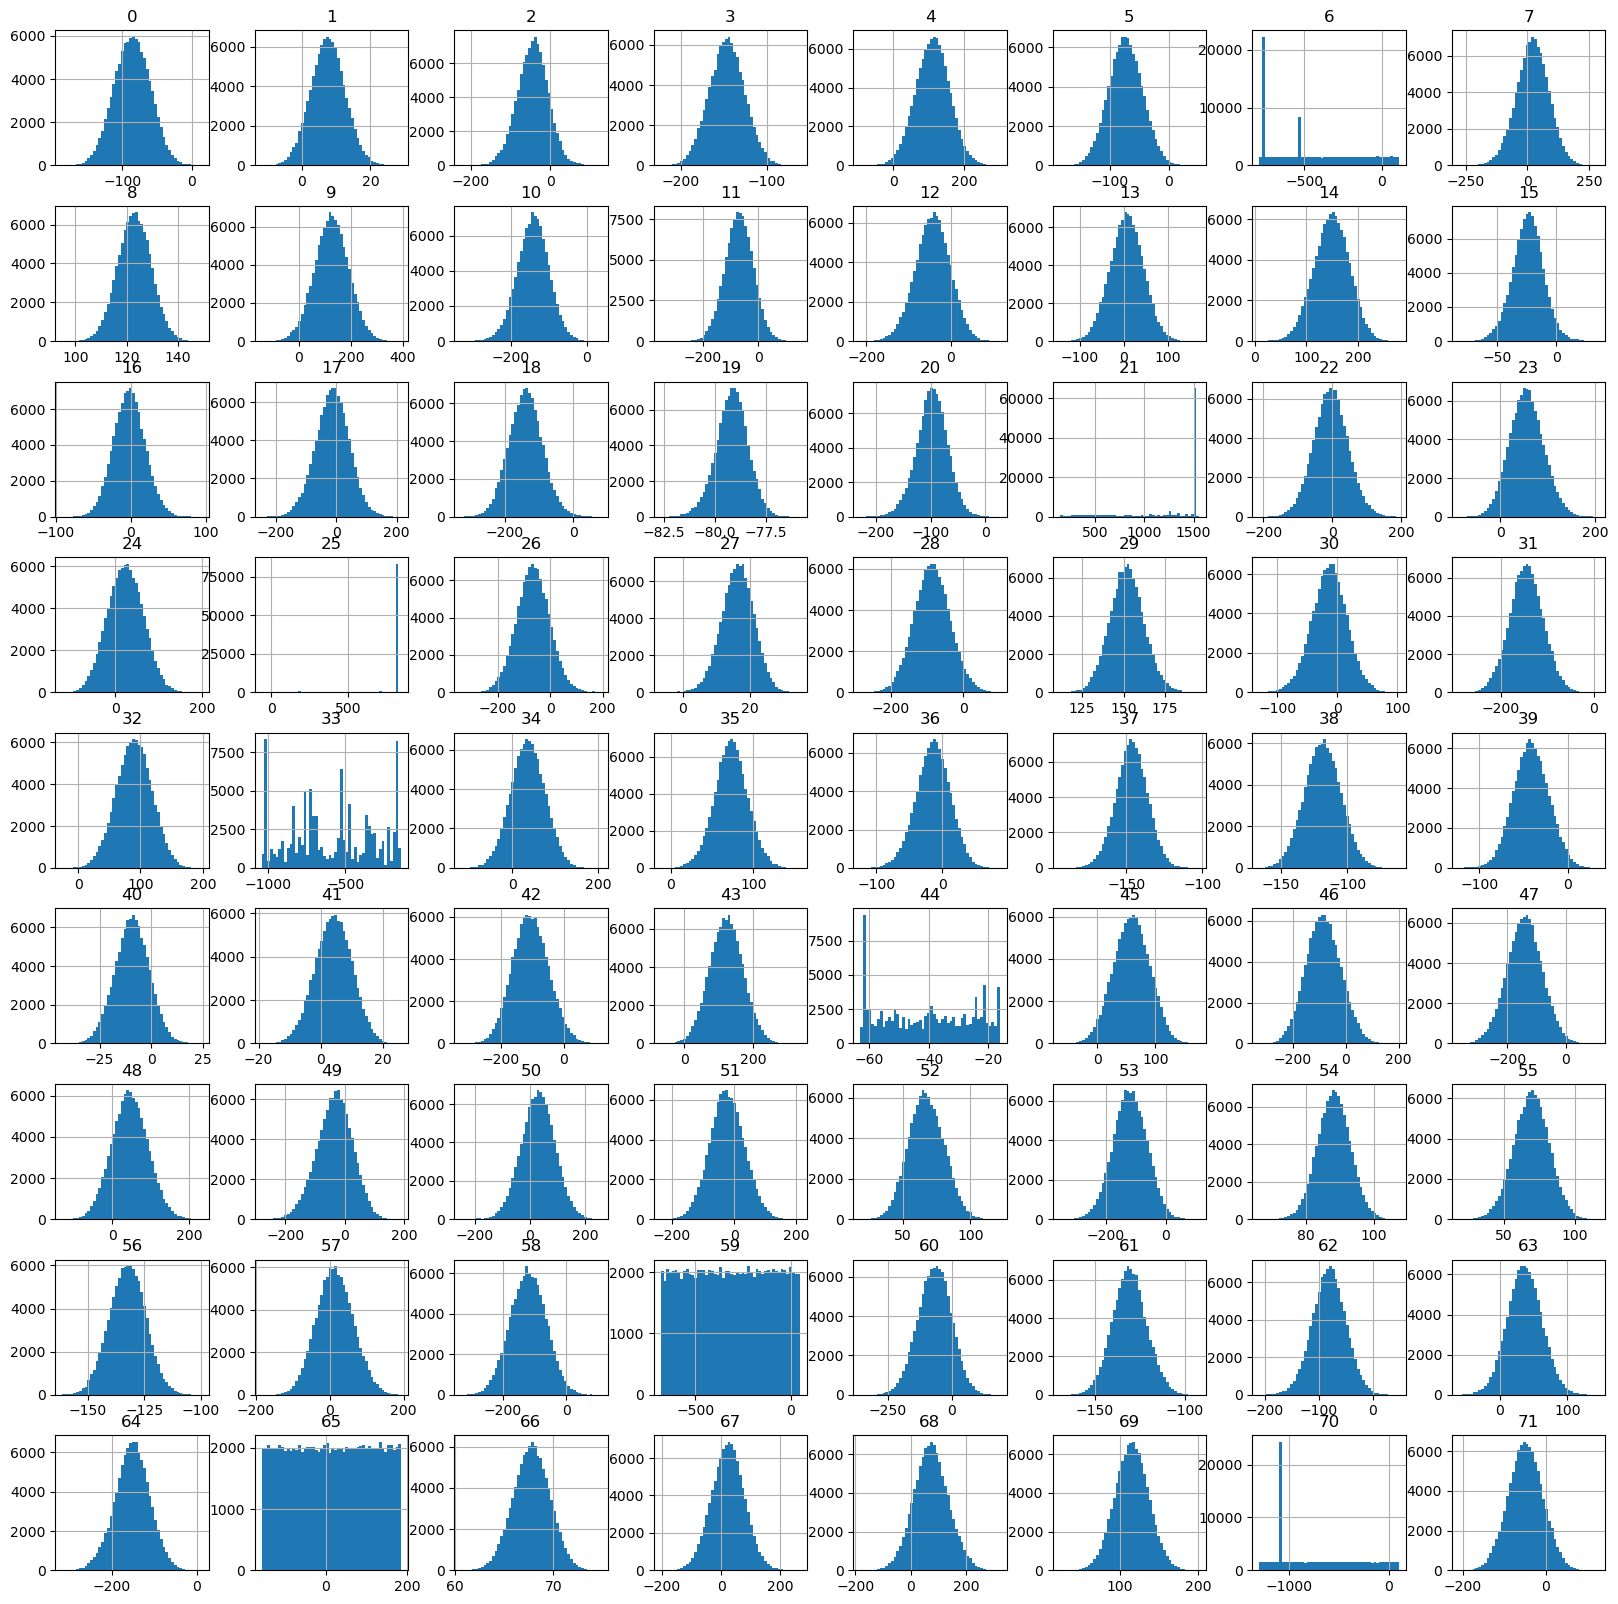

In [29]:
df_train.hist(figsize=[20, 20], bins=50);

#### Уберем лишние колонки с неправдободобным распределением, колонки 6, 21, 25, 44 и 70

In [30]:
cols_to_drop = ['70', '44', '25', '21', '6']

In [31]:
df_base.drop(columns=cols_to_drop, axis=1, inplace=True)

In [32]:
df_valid.drop(columns=cols_to_drop, axis=1, inplace=True)

In [33]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [34]:
targets2 = df_answer["Expected"]


In [35]:
df_train.drop(columns=cols_to_drop, axis=1, inplace=True)

Посмотрим что у нас все удалилось

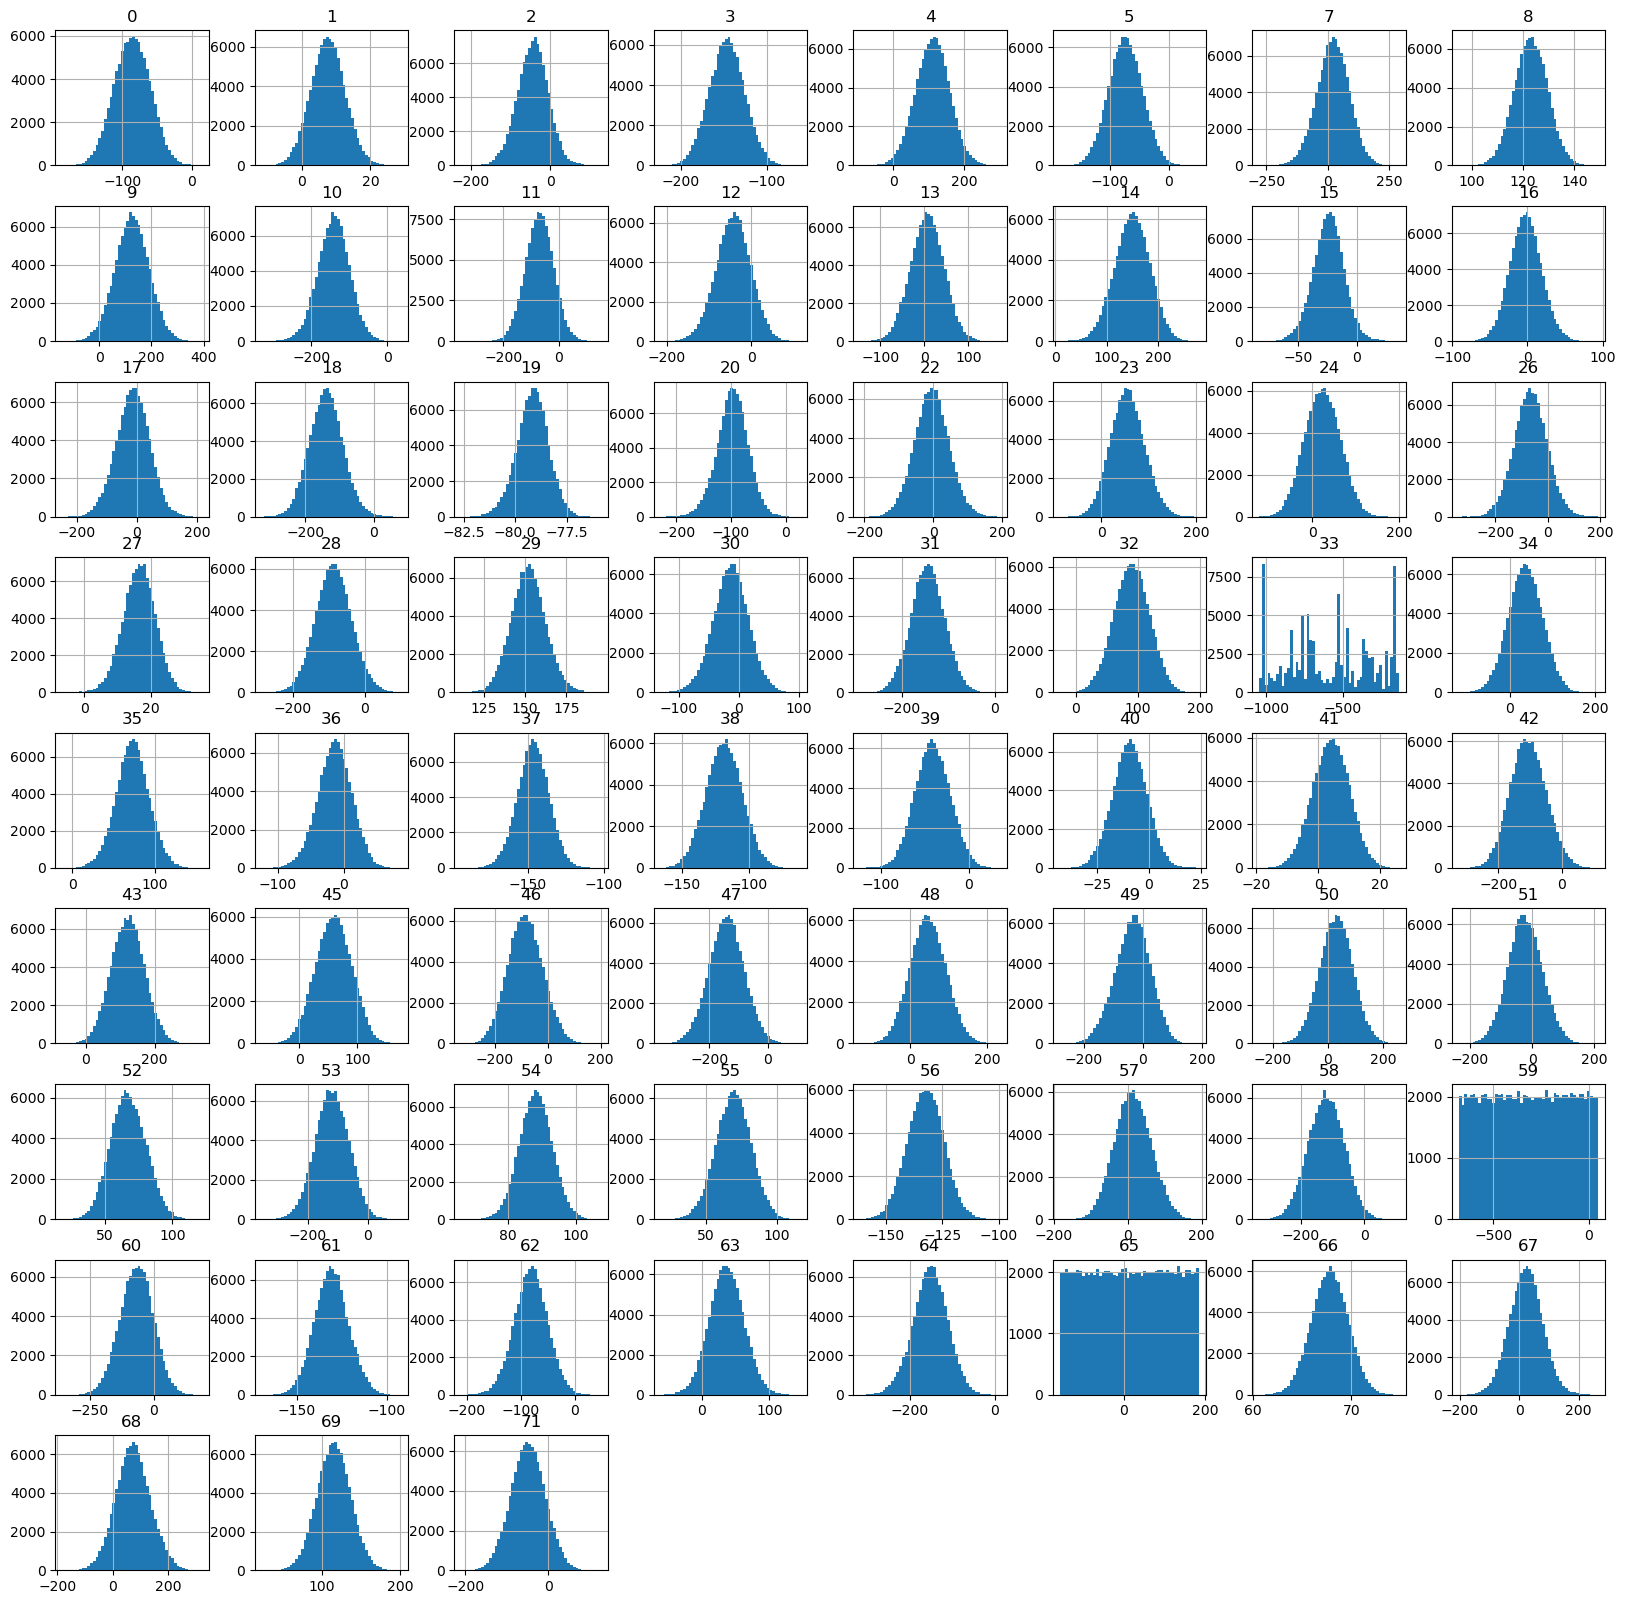

In [41]:
df_train.hist(figsize=[20, 20], bins=50);

#### Создадим словарь для быстрого поиска индексов по номеру запроса

In [37]:
df_base.index

Index(['0-base', '1-base', '2-base', '3-base', '4-base', '5-base', '6-base',
       '7-base', '8-base', '9-base',
       ...
       '4744747-base', '4744748-base', '4744749-base', '4744753-base',
       '4744754-base', '4744755-base', '4744759-base', '4744762-base',
       '4744763-base', '4744766-base'],
      dtype='object', name='Id', length=2918139)

In [38]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [39]:
print(base_index[1])

1-base


#### Произведем масштабирование признаков

Я сохраню отмасштабированные датасеты в отдельные, так как мне предстоит еще обучить ранжирующую модель, хочу иметь данные в исходном виде для этого

In [44]:
#scaler = RobustScaler()
df_base2 = scaler.fit_transform(df_base)
df_train2 = scaler.transform(df_train)



In [45]:
df_valid2 = scaler.transform(df_valid)

In [46]:
df_valid2.shape

(100000, 67)

In [47]:
df_base2.shape

(2918139, 67)

In [48]:
df_train2.shape

(100000, 67)

#### Создание индекса FAISS

Чем больше n_cells (количество центроидов для кластеров) - Тем быстрее осуществляется поиск ближайших соседей, так как 
В данном исследовании мы проверим 1)какую точность в поиске соседей может нам дать faiss, измерим время поиска
Также попробуем сократить время поиска или улучшить accuracy взяв крупное количество кластеров и применив отдельно обученную ранжирующую модель

In [92]:
dims = df_base2.shape[1]
n_cells = 10
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [93]:
## измерим время выполнения кода 
start = time.time() 
idx_l2.train(np.ascontiguousarray(df_base2[:250000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))
end = time.time() - start 
print(f' time s = {round(end)}')

 time s = 3


In [94]:
## Измерим время работы поиска
start = time.time() 

k=5
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f' accuracy = {100 * acc / len(idx)}')

end = time.time() - start 
print(f' time s = {round(end)}')

 accuracy = 59.616
 time s = 319


Хорошая accuracy, но очень долгое время выполнения кода.
Теперь попробуем сильно увеличить n_cells, я предположу что время выполнения кода сильно снизится, но наряду с этим упадет и точность

In [87]:
dims = df_base2.shape[1]
n_cells = 2000
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)


In [88]:
## также, измерим время выполнения кода 
start = time.time() 
idx_l2.train(np.ascontiguousarray(df_base2[:250000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))
end = time.time() - start 
print(f' time s = {round(end)}')

 time s = 1056


In [91]:
## также, измерим время выполнения кода 
start = time.time() 

k=5
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f' accuracy = {100 * acc / len(idx)}')

end = time.time() - start 
print(f' time s = {round(end)}')

 accuracy = 54.984
 time s = 4


In [99]:
dims = df_base2.shape[1]
n_cells = 150
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [100]:
## также, измерим время выполнения кода 
start = time.time() 
idx_l2.train(np.ascontiguousarray(df_base2[:250000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))
end = time.time() - start 
print(f' time s = {round(end)}')

 time s = 21


In [101]:
## также, измерим время выполнения кода 
start = time.time() 

k=5
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f' accuracy = {100 * acc / len(idx)}')

end = time.time() - start 
print(f' time s = {round(end)}')

 accuracy = 60.294
 time s = 21


In [106]:
## также, измерим время выполнения кода 
start = time.time() 

k=200
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(f' accuracy = {100 * acc / len(idx)}')

end = time.time() - start 
print(f' time s = {round(end)}')

 accuracy = 68.329
 time s = 28


Я нашел более-менее оптимальные параметры для индекса faiss: 200 соседей с точностью 68.3 за 28 секунд для 100000 запросов!

Теперь с помощью модели машинного обучения попробуем выбрать по 5 для каждого, и посчитаем время

In [107]:
nbrs = idx.tolist()

Получили список списков с ответами, далее преобразуем его в датафрейм, который впоследтсвии скормим модели машинного обучения

In [104]:
print(nbrs[1])

[15185, 223456, 902634, 464427, 311357, 2584784, 2469267, 1325497, 1007827, 124343, 1252594, 295462, 2151558, 51220, 1149318, 1238630, 1627647, 1012984, 395014, 2747244, 781791, 1989833, 838522, 1540755, 2733705, 690454, 1854808, 193752, 2709823, 722763, 357613, 857560, 1503950, 2604152, 2058066, 1147933, 2843018, 370540, 1494616, 1672464, 1393708, 2694334, 413070, 180047, 1252285, 1415723, 904384, 1917802, 1230304, 372055, 1405553, 1592384, 2398814, 1322784, 2419689, 2070954, 1844792, 944390, 217284, 2760055, 1036673, 2202245, 1946148, 372246, 962111, 2186413, 2037983, 2536539, 1340748, 2162616, 485998, 923913, 2356210, 749706, 2700717, 1146066, 1717764, 459531, 704508, 2607445, 1416039, 482141, 38990, 2090070, 1911426, 2391323, 2876234, 402456, 2425846, 1457365, 836689, 1931239, 1949511, 176701, 2133, 2486275, 2709743, 2314690, 1101570, 1022275]


In [52]:
filter_list = []
for i in nbrs[1]:
    filter_list.append(base_index[i])

In [53]:
filter_list

['15226-base',
 '577617-base',
 '234491-base',
 '1075687-base',
 '3883204-base',
 '511045-base',
 '332510-base',
 '4010195-base',
 '3766913-base',
 '1695903-base',
 '1222970-base',
 '127768-base',
 '1583399-base',
 '314505-base',
 '3130670-base',
 '51812-base',
 '1428166-base',
 '1562217-base',
 '2185351-base',
 '1230290-base',
 '428831-base',
 '4361410-base',
 '912080-base',
 '2826376-base',
 '988032-base',
 '2040608-base',
 '4331734-base',
 '792604-base',
 '2580329-base',
 '202060-base']